In [36]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from mvl2 import genData2
import numpyro
from mvl2.numpyro import model, model_mvn, infer, run
from torch import tensor
import matplotlib.pyplot as plt
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI
from numpyro.infer.autoguide import *
from numpyro.infer.elbo import TraceGraph_ELBO
from jax import random

In [19]:
r_p = tensor([[1., 0], [0, 1.]])
r_g = tensor([[1., .5], [.5, 1.]])
v_p = tensor([.05, .05])
h2 = tensor([.9, .9])

popgen_params = genData2.get_popgen_param(h2=h2, v_p=v_p, r_p=r_p, r_g=r_g)

sim_params = {
    "pi": tensor([.1, .1, .05]),
    **popgen_params,
    "RR_mean": tensor([3., 2.]),
    "PV_shape": tensor(1.),
    "PV_mean": tensor(1e-4),
    "PD": tensor([.01, .01]),
    "n_cases": tensor([1.5e4, 1.5e4, 4e3]),
    "n_ctrls": tensor(5e4),
    "fudge_factor": .1
}
sim_data = genData2.gen_counts(**sim_params)


/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pd = tensor([*PDV_single, PD12V])


disease_z_scores tensor([-2.3263, -2.3263])
PD_with_both tensor([1.0000e-02, 1.0000e-02, 1.0000e-04], dtype=torch.float64)
mean_effects tensor([-0.4456, -0.2726])
disease_z_scores: tensor([-2.3263, -2.3263])
pd: tensor([0.0341, 0.0219, 0.0007], dtype=torch.float64)
disease_z_scores: tensor([-2.3263, -2.3263])
pd: tensor([0.0427, 0.0201, 0.0009], dtype=torch.float64)
disease_z_scores: tensor([-2.3263, -2.3263])
pd: tensor([0.0100, 0.0182, 0.0002], dtype=torch.float64)
disease_z_scores: tensor([-2.3263, -2.3263])
pd: tensor([0.0295, 0.0100, 0.0003], dtype=torch.float64)
disease_z_scores: tensor([-2.3263, -2.3263])
pd: tensor([0.0100, 0.0217, 0.0002], dtype=torch.float64)
disease_z_scores: tensor([-2.3263, -2.3263])
pd: tensor([0.0365, 0.0232, 0.0008], dtype=torch.float64)
disease_z_scores: tensor([-2.3263, -2.3263])
pd: tensor([0.0301, 0.0100, 0.0003], dtype=torch.float64)
disease_z_scores: tensor([-2.3263, -2.3263])
pd: tensor([0.0100, 0.0203, 0.0002], dtype=torch.float64)
disease_z_sco

KeyboardInterrupt: 

In [4]:
sim_data["PVDs"].mean(0)

tensor([0.0001, 0.0001, 0.0001, 0.0002], dtype=torch.float64)

In [5]:
print(sim_data["PVDs"][sim_data["unaffected_genes"]].mean(0))
for i in range(len(sim_data["affected_genes"])):
    print(f"mean affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].mean(0))
    print(f"std affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].std(0))


tensor([0.0001, 0.0001, 0.0001, 0.0001], dtype=torch.float64)
mean affects 1 tensor([9.8241e-05, 9.9264e-05, 1.9852e-04, 1.9852e-04], dtype=torch.float64)
std affects 1 tensor([0.0001, 0.0001, 0.0002, 0.0002], dtype=torch.float64)
mean affects 2 tensor([9.5778e-05, 3.0308e-04, 2.0183e-04, 6.2602e-04], dtype=torch.float64)
std affects 2 tensor([9.9955e-05, 3.3260e-04, 2.2115e-04, 7.3668e-04], dtype=torch.float64)
mean affects 3 tensor([9.5165e-05, 2.9220e-04, 9.7175e-05, 2.9220e-04], dtype=torch.float64)
std affects 3 tensor([9.7266e-05, 2.9917e-04, 9.9319e-05, 2.9917e-04], dtype=torch.float64)


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


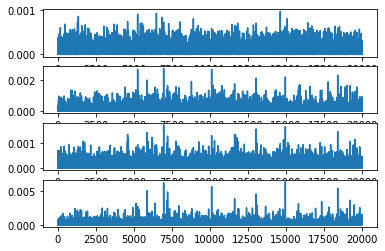

In [6]:
fig, plts = plt.subplots(sim_data["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data["PVDs"][:, i])

In [7]:
sim_params_point_pv = sim_params.copy()
sim_params_point_pv["PV_shape"] = None
sim_data_point_pv = genData2.gen_counts(**sim_params_point_pv)

/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PV = tensor(PV_mean).expand([n_genes,])
/home/akotlar/tada/project/mvl2/genData2.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))


disease_z_scores tensor([-2.3263, -2.3263])
PD_with_both tensor([1.0000e-02, 1.0000e-02, 1.0000e-04], dtype=torch.float64)
mean_effects tensor([-0.4456, -0.2726])


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


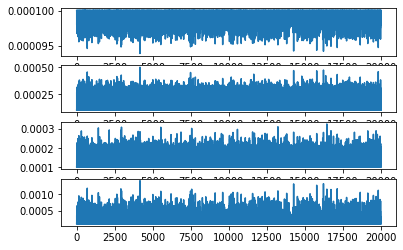

In [8]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data_point_pv["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data_point_pv["PVDs"][:, i])

In [9]:
run_params = {
    "data": sim_data_point_pv["alt_counts"].numpy(),
    "n_cases": sim_params_point_pv["n_cases"].numpy(),
    "n_ctrls": sim_params_point_pv["n_ctrls"].numpy(),
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 12,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}



In [15]:
sim_params_point_pv["n_cases"]

tensor([15000., 15000.,  4000.])

In [10]:
numpyro.enable_x64(False)
run_params_2 = run_params.copy()
run_params_2['max_K'] = 4
mcmc1, inferred_params1 = run(sim_data=sim_data_point_pv, run_params=run_params_2)

sample: 100%|██████████| 1200/1200 [00:40<00:00, 29.97it/s, 63 steps of size 8.52e-02. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.51      0.29      0.51      0.04      0.92   1728.62      1.00
   beta[1]      0.50      0.29      0.50      0.06      0.95   1804.29      1.00
   beta[2]      0.50      0.28      0.49      0.06      0.93   1318.74      1.00
 conc[0,0]      1.73      1.61      1.26      0.01      3.99    815.58      1.00
 conc[0,1]      5.92      5.70      4.25      0.04     13.04   1048.75      1.00
 conc[0,2]      5.56      5.51      3.85      0.00     12.20   1188.49      1.00
 conc[0,3]     20.65     20.73     14.02      0.03     46.18   1031.12      1.00
 conc[1,0]      1.71      1.76      1.16      0.02      4.03    340.33      1.00
 conc[1,1]      5.96      5.98      4.05      0.03     13.35    543.91      1.00
 conc[1,2]      5.56      5.39      3.87      0.06     12.90    889.40      1.00
 conc[1,3]     21.65     22.46     15.11      0.09     50.64    786.38      1.00
 conc[2,0]      1.62      1

In [11]:
mcmc1_b, inferred_params1_b = run(sim_data=sim_data_point_pv, run_params=run_params_2)

sample: 100%|██████████| 1200/1200 [00:39<00:00, 30.53it/s, 31 steps of size 1.11e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.21      0.07      0.20      0.10      0.30    205.50      1.00
   beta[1]      0.71      0.03      0.72      0.67      0.76    223.27      1.00
   beta[2]      0.32      0.07      0.31      0.20      0.43    315.28      1.01
 conc[0,0]      4.68      2.66      4.24      0.73      8.61    772.52      1.01
 conc[0,1]      2.63      1.56      2.39      0.21      4.73    765.65      1.00
 conc[0,2]      3.83      2.15      3.38      0.62      6.90    590.59      1.00
 conc[0,3]      1.77      1.15      1.54      0.16      3.33   1091.06      1.00
 conc[1,0]      4.69      3.01      4.06      0.33      8.81    842.75      1.00
 conc[1,1]      2.50      1.65      2.19      0.02      4.67    509.50      1.00
 conc[1,2]      2.53      1.58      2.19      0.27      4.74    715.58      1.00
 conc[1,3]      1.26      0.86      1.11      0.02      2.33   1467.74      1.00
 conc[2,0]      4.04      2

In [12]:
mcmc1_c, inferred_params1_c = run(sim_data=sim_data_point_pv, run_params=run_params_2)

sample: 100%|██████████| 1200/1200 [00:39<00:00, 30.02it/s, 63 steps of size 8.52e-02. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.51      0.29      0.51      0.04      0.92   1728.62      1.00
   beta[1]      0.50      0.29      0.50      0.06      0.95   1804.29      1.00
   beta[2]      0.50      0.28      0.49      0.06      0.93   1318.74      1.00
 conc[0,0]      1.73      1.61      1.26      0.01      3.99    815.58      1.00
 conc[0,1]      5.92      5.70      4.25      0.04     13.04   1048.75      1.00
 conc[0,2]      5.56      5.51      3.85      0.00     12.20   1188.49      1.00
 conc[0,3]     20.65     20.73     14.02      0.03     46.18   1031.12      1.00
 conc[1,0]      1.71      1.76      1.16      0.02      4.03    340.33      1.00
 conc[1,1]      5.96      5.98      4.05      0.03     13.35    543.91      1.00
 conc[1,2]      5.56      5.39      3.87      0.06     12.90    889.40      1.00
 conc[1,3]     21.65     22.46     15.11      0.09     50.64    786.38      1.00
 conc[2,0]      1.62      1

In [13]:
mcmc1_c2, inferred_params1_c2 = run(sim_data=sim_data_point_pv, run_params=run_params_2)

sample: 100%|██████████| 1200/1200 [00:39<00:00, 30.13it/s, 63 steps of size 8.52e-02. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.51      0.29      0.51      0.04      0.92   1728.62      1.00
   beta[1]      0.50      0.29      0.50      0.06      0.95   1804.29      1.00
   beta[2]      0.50      0.28      0.49      0.06      0.93   1318.74      1.00
 conc[0,0]      1.73      1.61      1.26      0.01      3.99    815.58      1.00
 conc[0,1]      5.92      5.70      4.25      0.04     13.04   1048.75      1.00
 conc[0,2]      5.56      5.51      3.85      0.00     12.20   1188.49      1.00
 conc[0,3]     20.65     20.73     14.02      0.03     46.18   1031.12      1.00
 conc[1,0]      1.71      1.76      1.16      0.02      4.03    340.33      1.00
 conc[1,1]      5.96      5.98      4.05      0.03     13.35    543.91      1.00
 conc[1,2]      5.56      5.39      3.87      0.06     12.90    889.40      1.00
 conc[1,3]     21.65     22.46     15.11      0.09     50.64    786.38      1.00
 conc[2,0]      1.62      1

In [22]:
inferred_params1_c2

({'beta': DeviceArray([[0.20372517, 0.10079853, 0.25999212],
               [0.7286004 , 0.08309828, 0.6292984 ],
               [0.20202202, 0.56071055, 0.63856   ],
               ...,
               [0.32202458, 0.569606  , 0.24525237],
               [0.9065287 , 0.6878937 , 0.5798403 ],
               [0.9049312 , 0.599721  , 0.6360395 ]], dtype=float32),
  'conc': DeviceArray([[[1.35708690e+00, 1.77518773e+00, 2.29539275e+00,
                 2.52151585e+01],
                [5.44665679e-02, 6.28611147e-01, 8.14443493e+00,
                 3.99755936e+01],
                [9.76935029e-01, 3.65100861e-01, 6.92664444e-01,
                 1.08581126e+00],
                [3.11722374e+00, 1.68773317e+00, 9.70522761e-01,
                 7.84414411e-01]],
  
               [[1.29114473e+00, 3.82880151e-01, 3.31931877e+00,
                 4.46846542e+01],
                [3.57490741e-02, 9.89186823e-01, 1.02595768e+01,
                 5.12765465e+01],
                [4.54221582e+00

In [34]:
pvd_pd_est = np.array(inferred_params1_c2[0]['probs'])
pvd_pd_est
# print(pvd_pd_est.shape)
# pvd_est = pvd_pd_est / sim_data_point_pv['PD_with_both']
# pvd_est

array([[[2.9636262e-02, 1.3275792e-01, 8.1817135e-02, 7.5578874e-01],
        [2.1592602e-03, 1.0093215e-02, 1.5970027e-01, 8.2804728e-01],
        [6.8257987e-01, 1.8190974e-01, 4.2470463e-02, 9.3039922e-02],
        [5.3489935e-01, 2.1052502e-01, 1.8761668e-01, 6.6958964e-02]],

       [[4.6058409e-02, 6.5037701e-04, 6.7245528e-02, 8.8604569e-01],
        [3.6551055e-04, 3.8654641e-03, 1.9293186e-01, 8.0283725e-01],
        [7.1489412e-01, 7.8194961e-02, 9.7493209e-02, 1.0941771e-01],
        [5.3819340e-01, 2.1014392e-01, 1.8458833e-01, 6.7074344e-02]],

       [[3.8834531e-02, 1.8777624e-01, 1.1719460e-02, 7.6166981e-01],
        [6.7836074e-05, 1.9898340e-01, 3.8438359e-01, 4.1656512e-01],
        [7.0075199e-02, 4.0754765e-01, 3.2866749e-01, 1.9370957e-01],
        [5.3796768e-01, 2.1065590e-01, 1.8469867e-01, 6.6677772e-02]],

       ...,

       [[6.6784550e-03, 1.1065235e-01, 5.4133797e-01, 3.4133127e-01],
        [1.7574988e-02, 1.0392152e-01, 4.4578743e-01, 4.3271607e-01],
 

In [31]:
import numpy as np


array([[[2.9636262e-02, 1.3275792e-01, 8.1817135e-02, 7.5578874e-01],
        [2.1592602e-03, 1.0093215e-02, 1.5970027e-01, 8.2804728e-01],
        [6.8257987e-01, 1.8190974e-01, 4.2470463e-02, 9.3039922e-02],
        [5.3489935e-01, 2.1052502e-01, 1.8761668e-01, 6.6958964e-02]],

       [[4.6058409e-02, 6.5037701e-04, 6.7245528e-02, 8.8604569e-01],
        [3.6551055e-04, 3.8654641e-03, 1.9293186e-01, 8.0283725e-01],
        [7.1489412e-01, 7.8194961e-02, 9.7493209e-02, 1.0941771e-01],
        [5.3819340e-01, 2.1014392e-01, 1.8458833e-01, 6.7074344e-02]],

       [[3.8834531e-02, 1.8777624e-01, 1.1719460e-02, 7.6166981e-01],
        [6.7836074e-05, 1.9898340e-01, 3.8438359e-01, 4.1656512e-01],
        [7.0075199e-02, 4.0754765e-01, 3.2866749e-01, 1.9370957e-01],
        [5.3796768e-01, 2.1065590e-01, 1.8469867e-01, 6.6677772e-02]],

       ...,

       [[6.6784550e-03, 1.1065235e-01, 5.4133797e-01, 3.4133127e-01],
        [1.7574988e-02, 1.0392152e-01, 4.4578743e-01, 4.3271607e-01],
 

In [21]:
sim_data_point_pv['PD_with_both']

tensor([1.0000e-02, 1.0000e-02, 1.0000e-04], dtype=torch.float64)

In [ ]:
numpyro.enable_x64(False)
run_params_2 = run_params.copy()
run_params_2['max_K'] = 6
mcmc2, inferred_params2 = run(sim_data=sim_data_point_pv, run_params=run_params_2)

In [10]:
numpyro.enable_x64(False)
mcmc3, inferred_params3 = run(sim_data=sim_data_point_pv, run_params=run_params)

sample:  52%|█████▏    | 626/1200 [06:10<05:49,  1.64it/s, 731 steps of size 8.99e-03. acc. prob=0.88]

In [12]:
numpyro.enable_x64(True)
mcmc4, inferred_params4 = run(sim_data=sim_data_point_pv, run_params=run_params)

sample: 100%|██████████| 1200/1200 [04:21<00:00,  4.59it/s, 63 steps of size 5.47e-02. acc. prob=0.84]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.68      0.03      0.69      0.62      0.73    129.79      1.01
    beta[1]      0.52      0.06      0.52      0.42      0.61    197.11      1.00
    beta[2]      0.60      0.12      0.61      0.42      0.79     36.98      1.04
    beta[3]      0.89      0.29      1.00      0.44      1.00      9.10      1.12
    beta[4]      0.95      0.16      1.00      0.87      1.00    413.01      1.00
    beta[5]      0.93      0.17      1.00      0.76      1.00    616.13      1.00
    beta[6]      0.94      0.16      1.00      0.80      1.00    669.78      1.00
    beta[7]      0.93      0.17      1.00      0.78      1.00    666.96      1.00
    beta[8]      0.94      0.15      1.00      0.79      1.00    783.13      1.00
    beta[9]      0.93      0.17      1.00      0.78      1.00    627.90      1.00
   beta[10]      0.94      0.17      1.00      0.80      1.00    674.42      1.00
  conc[0,0]    

In [14]:
# Initial attempt at variational inference, not working yet
data = run_params['data']
n_cases = run_params['n_cases']
n_ctrls = run_params['n_ctrls']
max_K = run_params['max_K']

guide = AutoNormal(model)
svi = SVI(model, guide, optim.Adam(0.01), TraceGraph_ELBO())
svi_state = svi.init(random.PRNGKey(0), data, n_cases, n_ctrls, max_K)
svi_result = svi.run(random.PRNGKey(1), 1000)
guide_samples = guide.sample_posterior(random.PRNGKey(2), svi_result.params)
guide_samples

ValueError: Continuous inference cannot handle discrete sample site 'z'.

In [12]:
import pandas as pd
df = pd.read_csv('/home/akotlar/tada/project/sim/test_dave3.csv')
pds = tensor([0.028, 0.028, 0.0024])
pd_with_both = tensor([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

array([[35,  2,  1,  0],
       [33,  0,  4,  0],
       [31,  1,  3,  0],
       ...,
       [46,  0,  0,  0],
       [33,  0,  0,  0],
       [31,  0,  0,  0]])

In [4]:
run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": True
}

numpyro.enable_x64(False)
mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:12<00:00, 97.35it/s, 7 steps of size 3.50e-01. acc. prob=0.87] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.80      0.01      0.80      0.79      0.81    566.76      1.00
   beta[1]      0.37      0.02      0.37      0.34      0.40    422.92      1.00
   beta[2]      0.31      0.03      0.31      0.26      0.35    455.26      1.01
probs[0,0]      0.94      0.00      0.94      0.94      0.94    884.14      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03    988.81      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03    680.87      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00    997.70      1.00
probs[1,0]      0.85      0.00      0.85      0.85      0.86    583.79      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02    576.25      1.00
probs[1,2]      0.12      0.00      0.12      0.12      0.12    506.14      1.00
probs[1,3]      0.01      0.00      0.01      0.01      0.01    707.39      1.00
probs[2,0]      0.80      0

In [5]:
numpyro.enable_x64(False)
run_params_dave_6 = run_params_dave.copy()
run_params_dave_6['max_K'] = 6
mcmc_dave_6, inferred_params_dave_6 = run(sim_data={}, run_params=run_params_dave_6)

sample: 100%|██████████| 1200/1200 [01:34<00:00, 12.74it/s, 127 steps of size 4.56e-02. acc. prob=0.78]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.76      0.02      0.77      0.74      0.79     84.64      1.01
   beta[1]      0.08      0.06      0.06      0.01      0.16     29.62      1.02
   beta[2]      0.37      0.05      0.37      0.31      0.42     91.25      1.00
   beta[3]      0.28      0.03      0.28      0.23      0.33    110.48      1.00
   beta[4]      0.16      0.09      0.16      0.00      0.28     79.77      1.00
probs[0,0]      0.94      0.00      0.94      0.94      0.95    152.48      1.02
probs[0,1]      0.03      0.00      0.03      0.03      0.03     34.83      1.04
probs[0,2]      0.03      0.00      0.03      0.02      0.03     79.52      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00    146.08      1.01
probs[1,0]      0.81      0.02      0.81      0.78      0.84     54.28      1.01
probs[1,1]      0.01      0.00      0.01      0.01      0.02    105.17      1.00
probs[1,2]      0.17      0

In [35]:
from jax import random
from numpyro.distributions import MultivariateNormal, Normal
from jax.nn import softmax, softplus
from numpyro import *
rng_key = random.PRNGKey(0)
import numpy as np
from scipy.stats import norm

print("pd_with_both", pd_with_both)

with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    print( 1- np.array(pd_with_both))
    z_scores = Normal(0,1).icdf(np.array(pd_with_both))
    x = numpyro.sample('x', MultivariateNormal(z_scores, 1.), sample_shape=(100,4))    # uses a PRNGKey split from random.PRNGKey(0)
    print("x:", x)
    print(softmax(x, 1))

pd_with_both tensor([0.9416, 0.0280, 0.0280, 0.0024])
[0.05839998 0.972      0.972      0.9976    ]
x: [[[ 2.546823   -0.9325607  -0.9325607  -1.841683  ]
  [ 2.2777395  -1.201644   -1.201644   -2.1107664 ]
  [ 3.1553988  -0.32398486 -0.32398486 -1.2331072 ]
  [ 1.0925624  -2.3868213  -2.3868213  -3.2959435 ]]

 [[ 1.5714732  -1.9079103  -1.9079103  -2.8170328 ]
  [ 1.8544437  -1.6249399  -1.6249399  -2.5340624 ]
  [ 1.1376345  -2.3417492  -2.3417492  -3.2508714 ]
  [ 0.13627589 -3.3431077  -3.3431077  -4.25223   ]]

 [[ 2.8981075  -0.58127606 -0.58127606 -1.4903984 ]
  [ 2.320273   -1.1591108  -1.1591108  -2.068233  ]
  [ 3.0375624  -0.44182122 -0.44182122 -1.3509436 ]
  [ 1.629484   -1.8498995  -1.8498995  -2.7590218 ]]

 ...

 [[ 0.9039824  -2.5754013  -2.5754013  -3.4845235 ]
  [ 2.380455   -1.0989287  -1.0989287  -2.008051  ]
  [ 1.9188781  -1.5605056  -1.5605056  -2.4696279 ]
  [ 2.998932   -0.4804517  -0.4804517  -1.389574  ]]

 [[ 1.2266941  -2.2526896  -2.2526896  -3.1618118 ]

In [39]:
numpyro.enable_x64(False)
run_params_dave_mvn = run_params_dave.copy()
run_params_dave_mvn['model'] = model_mvn
mcmc_dave_mvn, inferred_params_dave_mvn = run(sim_data={}, run_params=run_params_dave_mvn)

TypeError: infer() got an unexpected keyword argument 'model'